In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
import copy
import gif
from IPython.display import Image
import random
from tqdm import tqdm
import time
import pickle



In [5]:
def animate(data, j, patch, head, joints):
    first = []
    second = []
    for i in joints:
        first.append(data[j][0][i])
        second.append(data[j][1][i])
    a = np.array([first, second])
    a = np.transpose(a)
    patch.set_xy(a)
    head.center = (data[j][0][5], data[j][1][5])
    return patch, head

# To create a gif image
@gif.frame
def plot_samples_normal(data, j):
    # draw the simulation
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)

    ax = plt.axes(xlim=(-1, 10), ylim=(-0.1, 3))


    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0, 0], [0, 0]], closed=None, fill=None, edgecolor="k")
    head = plt.Circle((0, 0), radius=0.15, fc="k", ec="k")
    ax.add_patch(patch)
    ax.add_patch(head)
    plt.title(f"total_distance: {data[j][0][5]:.2f}")
    animate(data, j, patch, head, joints)
    # ax.Line2D([-0.5, 0], [10, 0], color='black')

    step_size = 11 / len(data)

    # Add a progress bar rectangle at the bottom
    progress_bar_height = 0.1
    progress_bar_y = -0.1  # Position of the progress bar on the y-axis
    progress_bar = plt.Rectangle((-1, progress_bar_y), step_size*j, progress_bar_height, color='blue')
    ax.add_patch(progress_bar)

    # Add a border for the progress bar
    progress_bar_border = plt.Rectangle((-1, progress_bar_y), 11, progress_bar_height, fill=False, edgecolor='black', linewidth=1)
    ax.add_patch(progress_bar_border)



In [6]:
# plan is an array of 40 floating point numbers
def sim(plan):
    """
    Simulates the motion of a multi-jointed body based on a given plan.

    Parameters:
    plan (list of float): A list of control parameters for the simulation. Each element should be between -1 and 1.

    Returns:
    tuple:
        - data (list of list of list of float): A list of positions of the body parts at each time step. Each position is a list of two lists, representing the x and y coordinates of the body parts.
        - final_position (float): The final x-coordinate of the head (body part 5).

    The simulation involves:
    - Adjusting the control parameters to be within the range [-1, 1].
    - Initializing physical properties such as mass, edge lengths, spring constants, and damping factors.
    - Iteratively updating the positions and velocities of the body parts based on forces, torques, and constraints.
    - Handling contact with the ground and applying friction.
    - Recording the positions of the body parts at each time step.
    - Returning the recorded data and the final x-coordinate of the head.
    """
    for i in range(0, len(plan)):
        if plan[i] > 1:
            plan[i] = 1.0
        elif plan[i] < -1:
            plan[i] = -1.0

    dt = 0.1 # time step
    friction = 1.0 # friction coefficient
    gravity = 0.1 # gravity constant
    mass = [30, 10, 5, 10, 5, 10] # mass of body parts
    edgel = [0.5, 0.5, 0.5, 0.5, 0.9] # edge lengths
    edgesp = [160.0, 180.0, 160.0, 180.0, 160.0]    # spring constants
    edgef = [8.0, 8.0, 8.0, 8.0, 8.0]   # damping factors
    anglessp = [20.0, 20.0, 10.0, 10.0] # angular spring constants
    anglesf = [8.0, 8.0, 4.0, 4.0]  # angular damping factors

    edge = [(0, 1), (1, 2), (0, 3), (3, 4), (0, 5)] # edges
    angles = [(4, 0), (4, 2), (0, 1), (2, 3)] # angles

    # vel and pos of the body parts, 0 is hip, 5 is head, others are joints
    v = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    p = [[0, 0, -0.25, 0.25, 0.25, 0.15], [1, 0.5, 0, 0.5, 0, 1.9]]

    spin = 0.0
    maxspin = 0.0
    lastang = 0.0

    data = []

    for j in range(20): # 20 time steps
        for k in range(10): # 10 substeps
            lamb = 0.05 + 0.1 * k 
            t0 = 0.5
            if j > 0:
                t0 = plan[2 * j - 2]
            t0 *= 1 - lamb
            t0 += plan[2 * j] * lamb

            t1 = 0.0
            if j > 0:
                t1 = plan[2 * j - 1]
            t1 *= 1 - lamb
            t1 += plan[2 * j + 1] * lamb

            contact = [False, False, False, False, False, False]
            for z in range(6):
                if p[1][z] <= 0:
                    contact[z] = True
                    spin = 0
                    p[1][z] = 0

            anglesl = [-(2.8 + t0), -(2.8 - t0), -(1 - t1) * 0.9, -(1 + t1) * 0.9] 

            disp = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            dist = [0, 0, 0, 0, 0]
            dispn = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                disp[0][z] = p[0][edge[z][1]] - p[0][edge[z][0]]
                disp[1][z] = p[1][edge[z][1]] - p[1][edge[z][0]]
                dist[z] = (
                    math.sqrt(disp[0][z] * disp[0][z] + disp[1][z] * disp[1][z]) + 0.01
                )
                inv = 1.0 / dist[z]
                dispn[0][z] = disp[0][z] * inv
                dispn[1][z] = disp[1][z] * inv 

            dispv = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            distv = [0, 0, 0, 0, 0]
            for z in range(5):
                dispv[0][z] = v[0][edge[z][1]] - v[0][edge[z][0]]
                dispv[1][z] = v[1][edge[z][1]] - v[1][edge[z][0]]
                distv[z] = 2 * (disp[0][z] * dispv[0][z] + disp[1][z] * dispv[1][z])

            forceedge = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                c = (edgel[z] - dist[z]) * edgesp[z] - distv[z] * edgef[z]
                forceedge[0][z] = c * dispn[0][z]
                forceedge[1][z] = c * dispn[1][z]

            edgeang = [0, 0, 0, 0, 0]
            edgeangv = [0, 0, 0, 0, 0]
            for z in range(5):
                edgeang[z] = math.atan2(disp[1][z], disp[0][z])
                edgeangv[z] = (dispv[0][z] * disp[1][z] - dispv[1][z] * disp[0][z]) / (
                    dist[z] * dist[z]
                )

            inc = edgeang[4] - lastang
            if inc < -math.pi:
                inc += 2.0 * math.pi
            elif inc > math.pi:
                inc -= 2.0 * math.pi
            spin += inc
            spinc = spin - 0.005 * (k + 10 * j)
            if spinc > maxspin:
                maxspin = spinc
                lastang = edgeang[4]

            angv = [0, 0, 0, 0]
            for z in range(4): 
                angv[z] = edgeangv[angles[z][1]] - edgeangv[angles[z][0]]

            angf = [0, 0, 0, 0]
            for z in range(4):
                ang = edgeang[angles[z][1]] - edgeang[angles[z][0]] - anglesl[z]
                if ang > math.pi:
                    ang -= 2 * math.pi
                elif ang < -math.pi:
                    ang += 2 * math.pi
                m0 = dist[angles[z][0]] / edgel[angles[z][0]]
                m1 = dist[angles[z][1]] / edgel[angles[z][1]]
                angf[z] = ang * anglessp[z] - angv[z] * anglesf[z] * min(m0, m1)

            edgetorque = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]
            for z in range(5):
                inv = 1.0 / (dist[z] * dist[z])
                edgetorque[0][z] = -disp[1][z] * inv
                edgetorque[1][z] = disp[0][z] * inv

            for z in range(4):
                i0 = angles[z][0]
                i1 = angles[z][1]
                forceedge[0][i0] += angf[z] * edgetorque[0][i0]
                forceedge[1][i0] += angf[z] * edgetorque[1][i0]
                forceedge[0][i1] -= angf[z] * edgetorque[0][i1]
                forceedge[1][i1] -= angf[z] * edgetorque[1][i1]

            f = [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]]
            for z in range(5):
                i0 = edge[z][0]
                i1 = edge[z][1]
                f[0][i0] -= forceedge[0][z]
                f[1][i0] -= forceedge[1][z]
                f[0][i1] += forceedge[0][z]
                f[1][i1] += forceedge[1][z]

            for z in range(6):
                f[1][z] -= gravity * mass[z]
                invm = 1.0 / mass[z]
                v[0][z] += f[0][z] * dt * invm
                v[1][z] += f[1][z] * dt * invm

                if contact[z]:
                    fric = 0.0
                    if v[1][z] < 0.0:
                        fric = -v[1][z]
                        v[1][z] = 0.0

                    s = np.sign(v[0][z])
                    if v[0][z] * s < fric * friction:
                        v[0][z] = 0
                    else:
                        v[0][z] -= fric * friction * s
                p[0][z] += v[0][z] * dt
                p[1][z] += v[1][z] * dt

            data.append(copy.deepcopy(p))

            if contact[0] or contact[5]:
                return data, p[0][5]
    return data, p[0][5]

In [7]:
#Modified `sim` to only output the distance
def sim2(plan):
    _, total_distance = sim(plan)
    return total_distance

**Simulated Anneling**

In [5]:
class SimulatedAnnealing:
    def __init__(self, func, length=40, value_range=(-1, 1), initial_temp=1, cooling_rate=0.9,final_std_beta_dist=0.05,transformation_exponent=2,intial_alpha_beta=1,intial_solution=None):
        """
        transformation_exponent:  is the exponent for the transformation of the alpha_beta scheduler 
            transformation_exponent>1 give exponatial transformation for slower change in the beginning and faster at the end of the beta distribution and vice versa
        final_std_beta_dist: is the final standard deviation of the beta distribution when the iterations has reached the max_iterations
        """
        self.func = func
        self.length = length
        self.value_range = value_range
        self.initial_temp = initial_temp
        self.cooling_rate = cooling_rate
        self.best_value_history = []
        self.current_value_history = []
        self.probability_history = [0]
        self.intial_solution = intial_solution

        # Beta distribution parameters
        self.final_std_beta_dist = final_std_beta_dist
        self.transformation_exponent = transformation_exponent
        self.intial_alpha_beta = intial_alpha_beta


    def alpha_beta_schedule(self, iteration, max_iterations,final_alpha_beta):
        # transformation_exponent>1 give exponatial transformation for slower change in the beginning and faster at the end
        proprtion=iteration/max_iterations
        transformed_proportion = (proprtion) ** self.transformation_exponent
        alpha_beta = self.intial_alpha_beta + (final_alpha_beta - self.intial_alpha_beta) * (transformed_proportion)
        return alpha_beta
    
    def alpha_beta_schedule2(iteration,max_iterations,final_alpha):
        # Linearly interpolate alpha between 1 and final_alpha
        alpha = 1 + (final_alpha - 1) * (iteration / max_iterations)
        return alpha


    def run(self,min_temp=-np.inf,max_iterations=np.inf):
        if min_temp != -np.inf:
            max_iterations = int(np.log(min_temp/self.initial_temp)/np.log(self.cooling_rate))
            print(f"Number of iterations is: {max_iterations}")
        elif max_iterations == np.inf and min_temp == -np.inf:
            raise ValueError("Please provide either min_temp or max_iterations")
        if self.intial_solution is not None:
            current_solution = self.intial_solution
            print("Initial solution provided")
        else:
            current_solution = np.random.uniform(self.value_range[0], self.value_range[1], self.length)
        current_value = self.func(current_solution)

        best_solution = current_solution.copy()
        best_value = current_value
        self.best_value_history = np.zeros(max_iterations+1)
        self.best_value_history[0] = best_value
        self.current_value_history = np.zeros(max_iterations+1)
        self.current_value_history[0] = current_value

        self.acceptance_probability_history = np.zeros(max_iterations+1)
        self.acceptance_probability_history[0] = 1

        
        #Paramters for the beta sampling
        final_alpha_beta = (1 / (8 * self.final_std_beta_dist**2)) - 0.5
        
      
        temperature = self.initial_temp
        for iteration in tqdm(range(max_iterations)):
            alpha_beta = self.alpha_beta_schedule(iteration,max_iterations,final_alpha_beta)
            #beta distrubution samples values in the range [-0.5,0.5]
            new_solution = current_solution + (np.random.beta(alpha_beta, alpha_beta, self.length)-0.5)
            #new_solution = np.mod(new_solution - self.value_range[0], self.value_range[1] - self.value_range[0]) + self.value_range[0]

            new_solution = np.maximum(self.value_range[0], np.minimum(new_solution, self.value_range[1]))
            new_value = self.func(new_solution)

            delta = new_value - current_value
            acceptance_probability = np.exp(delta / temperature) if delta < 0 else 1.0
            if delta < 0:
                self.acceptance_probability_history[iteration+1]=acceptance_probability
                
            else:
                self.acceptance_probability_history[iteration+1]=self.acceptance_probability_history[iteration]

            if np.random.rand() < acceptance_probability:
                current_solution = new_solution
                current_value = new_value
            self.current_value_history[iteration+1]=current_value
            
            if current_value > best_value:
                best_solution = current_solution.copy()
                best_value = current_value
                if best_value >=10.0:
                    print("Optimal solution found")
                    break
            self.best_value_history[iteration+1]=best_value
            temperature *= self.cooling_rate

        return best_solution
    




Number of iterations is: 240


100%|██████████| 240/240 [00:01<00:00, 232.82it/s]


Distance: 4.467886188368759


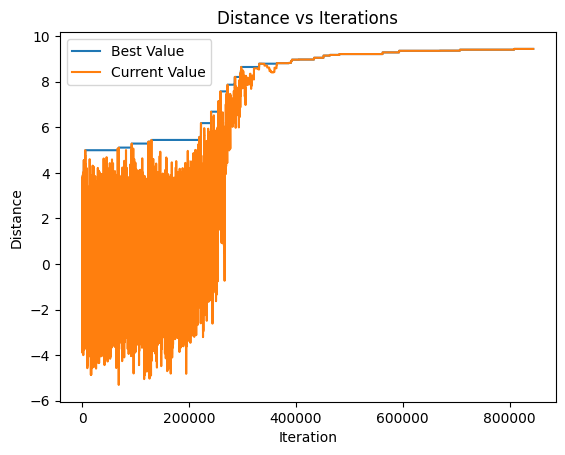

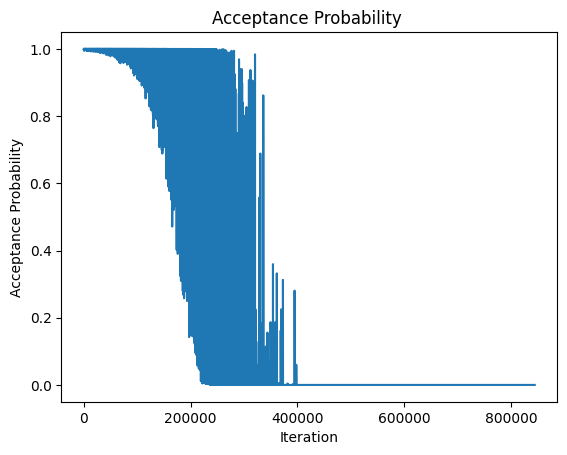

In [ ]:
sa=SimulatedAnnealing(
    func=sim2,
    length=40,
    value_range=(-1, 1),
    initial_temp=1000,
    cooling_rate=0.99997
)
planSA=sa.run(min_temp=10**(-8))
print(f"Distance: {sim2(planSA)}")

#load the data from sa_variables9439.pkl
#with open("sa_variables9439.pkl", "rb") as f:
#    sa_dict = pickle.load(f)
#sa= sa_dict["sa"]
#planSA = sa_dict["planSA"]

# Plotting the data
plt.plot(sa.best_value_history, label='Best Value')
plt.plot(sa.current_value_history, label='Current Value')
plt.xlabel("Iteration")
plt.ylabel("Distance")
plt.title("Distance vs Iterations")
plt.legend()  # Add legend to the plot
plt.show()

plt.figure()
plt.plot(sa.acceptance_probability_history)
plt.xlabel("Iteration")
plt.ylabel("Acceptance Probability")
plt.title("Acceptance Probability ")
plt.show()

In [ ]:
#Save the variables to a file
variables_to_save = {
    'acceptance_probability_history': sa.acceptance_probability_history,
    'best_value_history': sa.best_value_history,
    'current_value_history': sa.current_value_history,
    'planSA': planSA,
    'sa': sa
}

# Save the variables to a file
#with open('sa_variables9439.pkl', 'wb') as file:
#    pickle.dump(variables_to_save, file)


Plot of how the beta distribution change over time 

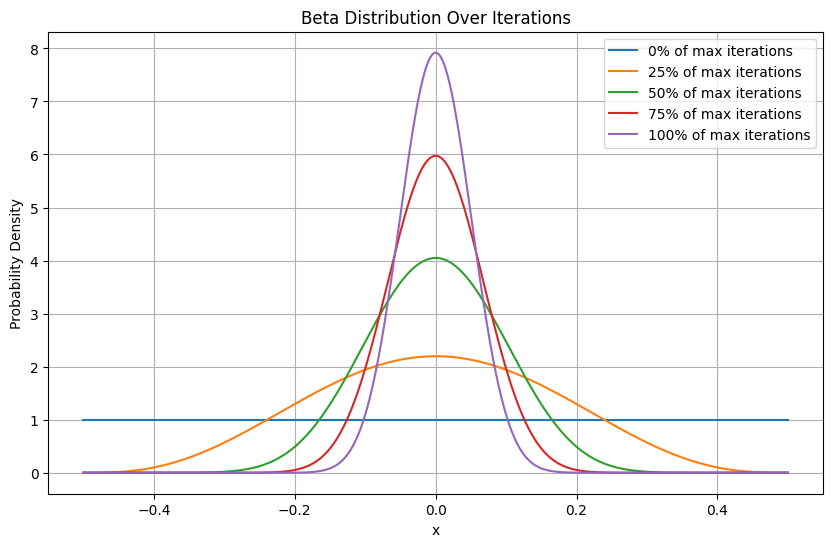

In [8]:
from scipy.stats import beta

def plot_beta_distribution(a, b, iteration, max_iterations):
    x = np.linspace(0, 1, 1000)
    y = beta.pdf(x, a, b)
    percentage =np.round(iteration/max_iterations*100)
    plt.plot(x-0.5, y, label=f'{percentage:.0f}% of max iterations')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title('Beta Distribution Over Iterations')
    plt.legend()

sa=SimulatedAnnealing(
    func=sim2,
    length=40,
    value_range=(-1, 1),
    initial_temp=1000,
    cooling_rate=0.999#97
    
)



# Parameters for the Beta distribution
a_initial = 1
b_initial = 1
a_final = 49.5
b_final = 49.5
max_iterations = 100

plt.figure(figsize=(10, 6))

percentages = np.linspace(0, 100, 5)  #
for iteration in range(max_iterations): 
    alpha_beta = sa.alpha_beta_schedule(iteration, max_iterations,a_final)
    if iteration/max_iterations*100 in percentages:
        plot_beta_distribution(alpha_beta, alpha_beta, iteration, max_iterations)

plot_beta_distribution(a_final, b_final, max_iterations, max_iterations)
plt.grid(True)
plt.show()

**Genetic Algorithm**

In [8]:
def calculate_fitness(chromosome, fitness_function):
    return fitness_function(chromosome)

class GeneticAlgorithm:
    def __init__(
        self,
        population_size,
        gene_type,
        gene_interval,
        chromosome_length,
        crossover_rate,
        mutation_rate,
        elitism_count,
        fitness_function,
        tournament_size=4,
        n_crossover_points=1
    ):
        self.population_size = population_size
        self.gene_type = gene_type
        self.gene_interval = gene_interval
        self.chromosome_length = chromosome_length
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elitism_count = elitism_count
        self.fitness_function = fitness_function
        self.tournament_size = tournament_size
        self.n_crossover_points = n_crossover_points

        if gene_type == "int":
            self.population = np.random.randint(
                gene_interval[0],
                gene_interval[1] + 1,
                size=(population_size, chromosome_length)
            )
        elif gene_type == "float":
            self.population = np.random.uniform(
                gene_interval[0],
                gene_interval[1],
                size=(population_size, chromosome_length)
            )
        else:
            raise ValueError("Invalid gene type")

        self.fitness = np.zeros(population_size, dtype=float)
        self.best_individual = None
        self.generation = 0

        self.calculate_population_fitness()
        self.best_individual = self.population[np.argmax(self.fitness)]
        self.generation = 0
        self.best_fitness_per_generation=[]

    def calculate_population_fitness(self):
        self.fitness = np.array([calculate_fitness(chromosome, self.fitness_function) for chromosome in self.population])


    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            crossover_points = sorted(random.sample(range(1, self.chromosome_length), self.n_crossover_points))
            child1 = np.copy(parent1)
            child2 = np.copy(parent2)
            for i in range(len(crossover_points)):
                start = crossover_points[i]
                end = crossover_points[i+1] if (i+1 < len(crossover_points)) else None
                if i % 2 == 0:
                    child1[start:end] = parent2[start:end]
                    child2[start:end] = parent1[start:end]
            return child1, child2
        return np.copy(parent1), np.copy(parent2)

    def mutate(self, chromosome):
        for i in range(self.chromosome_length):
            if random.random() < self.mutation_rate:
                if self.gene_type == "int":
                    chromosome[i] = random.randint(self.gene_interval[0], self.gene_interval[1])
                else:  # float
                    chromosome[i] = random.uniform(self.gene_interval[0], self.gene_interval[1])
        return chromosome

    def evolve(self):
        new_population = []
        
        sorted_indices = np.argsort(-self.fitness)  
        elites = self.population[sorted_indices[:self.elitism_count]]
        new_population.extend(elites)

        # Keep creating children until we have enough for the new population
        while len(new_population) < self.population_size:
            parent1 = self.select_parent()
            parent2 = self.select_parent()
            child1, child2 = self.crossover(parent1, parent2)
            child1 = self.mutate(child1)
            if len(new_population) < self.population_size:
                new_population.append(child1)
            child2 = self.mutate(child2)
            if len(new_population) < self.population_size:
                new_population.append(child2)

        self.population = np.array(new_population)
        self.calculate_population_fitness()
        self.best_individual = self.population[np.argmax(self.fitness)]
        self.best_fitness_per_generation.append(np.max(self.fitness))

        self.generation += 1

    def select_parent(self):
        """
        Tournament selection: random sample, choose best individual.
        """
    
        idx = np.random.randint(0, self.population_size, size=self.tournament_size)
        best_t_idx = idx[np.argmax(self.fitness[idx])]
        return self.population[best_t_idx].copy()

    def run(self, max_generation=1000, max_time_sec=np.inf):
        start_time = time.time()
        for i in tqdm(range(max_generation), desc="Generations", unit="generation"):
            elapsed_time = time.time() - start_time
            if elapsed_time > max_time_sec:
                print("Time limit reached. Stopping the process.")
                break
            if np.max(self.fitness) >= 10.0:
                print("Found a perfect solution. Stopping the process.")
                break
            self.evolve()

Generations: 100%|██████████| 3/3 [00:10<00:00,  3.51s/generation]

Best Individual: [ 0.19044121  0.97406373 -0.6246423  -0.18856989 -0.19009789 -0.0903887
  0.30102354  0.39013785 -0.54593297  0.10629736  0.637253    0.97222043
 -0.6803208  -0.47038517 -0.88578576  0.67664894 -0.31998952 -0.87974302
 -0.1865777  -0.95165772  0.96913671 -0.01297386  0.40514065  0.16591595
  0.5546872  -0.77882478  0.74308803 -0.48169808 -0.90344104 -0.21460695
 -0.76136185  0.01519777 -0.2552592   0.70050385  0.25579024  0.9014337
  0.65264051 -0.98203321 -0.10555886 -0.81114995]
Best Fitness: 5.576421653529456


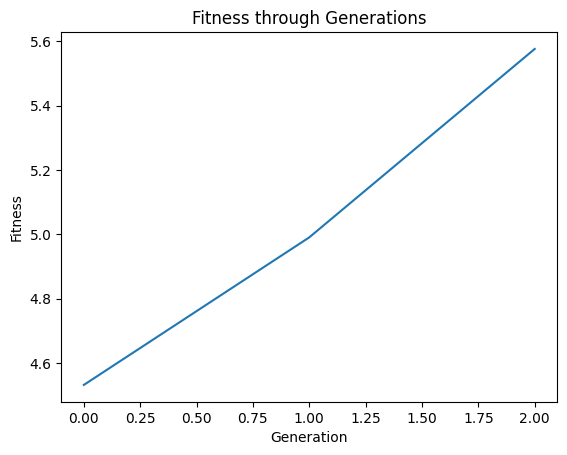

In [9]:

ga = GeneticAlgorithm(
    population_size=1000,
    gene_type="float",
    gene_interval=(-1, 1),
    chromosome_length=40,
    crossover_rate=0.9,
    n_crossover_points=3,
    mutation_rate=0.04,
    elitism_count=2,
    tournament_size=8,
    fitness_function=sim2
)

ga.run(900)
print(f"Best Individual: {ga.best_individual}")
print(f"Best Fitness: {ga.fitness_function(ga.best_individual)}")

plt.plot(ga.best_fitness_per_generation)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness through Generations")
plt.show()

In [11]:
#data, total_distance = sim(planGA)
#print("Total Distance = ", total_distance)

data, total_distance = sim(planSA)
print("Total Distance = ", total_distance)

Total Distance =  9.439504711230645


In [12]:
###########
# The following code is given as an example to store a video of the run and to display
# the run in a graphics window. You will treat sim(plan) as a black box objective
# function and maximize it.
###########
data, total_distance = sim([-0.11717214,0.87875168,-0.65974358,-0.92632747,-0.64279997,-0.85304578,
  0.42228431,  0.57250107 , 0.70036448,  0.98652103, -0.2499286,   0.9246037,
 -0.81725103 , 0.83885577, -0.79642535,  0.58261927, -0.96539297, -0.96219493,
  0.2557485 , -0.93066869,  0.75553554,  0.99997222,  0.49554113,  0.71036927,
 -0.99946246, -0.79149398, -0.51498707,  0.99749272, -0.94682206, -0.99979162,
 -0.27781658, -0.99937059,  0.48455117,  0.99913118, 0.05124076, 0.9985356,
  0.66838204,  0.99151644, -0.99979838, -0.99969885])
print("Total Distance = ", total_distance) 

Total Distance =  9.708503889686673


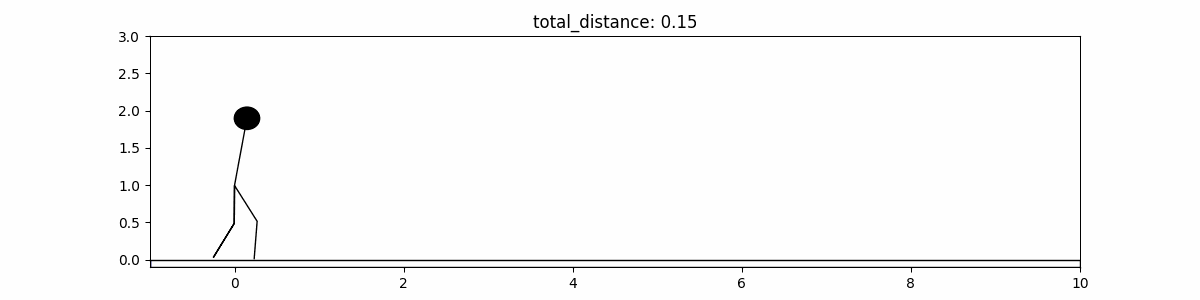

In [13]:
# Create a gif
frames = []
for j in range(len(data)):
    frame = plot_samples_normal(data, j)
    frames.append(frame)

gif.save(frames, "animation.gif", duration=40)
Image(filename="animation.gif")